In [75]:
import numpy as np # linear algebra
import pandas as pd

df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.rename(columns = {'Review':'review', 'Rating':'sentiment'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     20491 non-null  object
 1   sentiment  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [76]:
df.iloc[10,0]

"poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,  "

In [77]:
df.head()

,review,sentiment
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [78]:
df = df.replace({'sentiment' : {1:'negative', 2:'negative', 3:'neutral', 4:'positive', 5: 'positive' }})
df = df[df.sentiment != "neutral"]
df.head()

,review,sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,negative
3,"unique, great stay, wonderful time hotel monac...",positive
4,"great stay great stay, went seahawk game aweso...",positive
5,love monaco staff husband stayed hotel crazy w...,positive


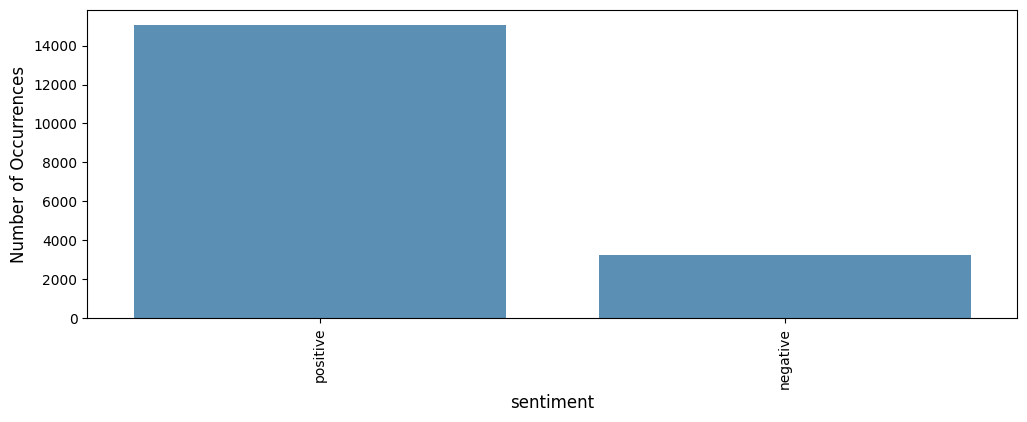

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [80]:
from bs4 import BeautifulSoup

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

In [81]:
!pip install contractions

In [82]:
import re
import nltk
import tqdm
import unicodedata
import contractions

from nltk.tokenize import word_tokenize

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)

  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [83]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [84]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
#%%time
# pre entrainement
df.review = pre_process_corpus(df.review)

  1%|          | 142/18307 [00:00<00:26, 689.94it/s]<ipython-input-80-be5d0f72bd36>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 18307/18307 [00:46<00:00, 393.37it/s]


In [86]:
from sklearn.utils import resample
# Separate majority and minority classes in training data for upsampling
data_majority = df[df['sentiment'] == "positive"]
data_minority = df[df['sentiment'] == "negative"]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority,
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_balance = pd.concat([data_majority, data_minority_upsampled])

# Display new class counts
print("After upsampling\n",df_balance.sentiment.value_counts(),sep = "")


majority class before upsample: (15093, 2)
minority class before upsample: (3214, 2)
After upsampling
sentiment
positive    15093
negative    15093
Name: count, dtype: int64


In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size=0.1, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((16476,), (1831,), (16476,), (1831,))

In [88]:
X_train[0]

'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay 40 parking night'

In [89]:
import keras
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_test)
t.word_index['<PAD>'] = 0

In [90]:
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

In [91]:
VOCAB_SIZE = len(t.word_index)

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=18529
Number of Documents=1831


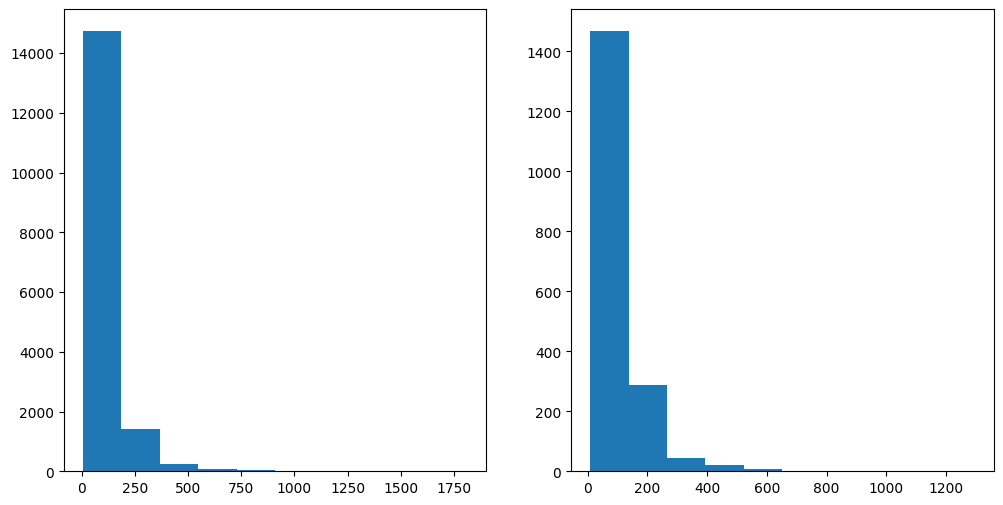

In [92]:
train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [93]:
MAX_SEQUENCE_LENGTH = 100

# pad dataset to a maximum review length in words
X_train = keras.utils.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = keras.utils.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((16476, 100), (1831, 100))

In [94]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [95]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [96]:
import keras
from keras.models import Model

In [97]:
input_layer = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = keras.layers.Dense(100)(input_layer)
x = keras.layers.Dense(100)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

dnn_model = Model(input_layer, output)

dnn_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['Accuracy'])

In [98]:
dnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,301 (79.30 KB)

 Trainable params: 20,301 (79.30 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
history = dnn_model.fit(X_train, y_train, batch_size=16, epochs=20)

Epoch 1/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - Accuracy: 0.6836 - loss: 254.9180
Epoch 2/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - Accuracy: 0.6919 - loss: 93.5115
Epoch 3/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - Accuracy: 0.6860 - loss: 48.8910
Epoch 4/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - Accuracy: 0.6881 - loss: 27.8693
Epoch 5/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Accuracy: 0.6916 - loss: 14.2185
Epoch 6/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Accuracy: 0.6927 - loss: 8.0639
Epoch 7/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Accuracy: 0.7026 - loss: 4.5934
Epoch 8/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Accuracy: 0.6965 - loss: 3.5031
Epoch 9/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Accuracy: 0.7025 - loss: 2.6596
Epoch 10/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Accuracy: 0.7055 - loss: 2.5857
Epoch 11/20
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Accuracy: 0.7068 - loss: 2.5681
Epoch 12/20
1030/1030 ━

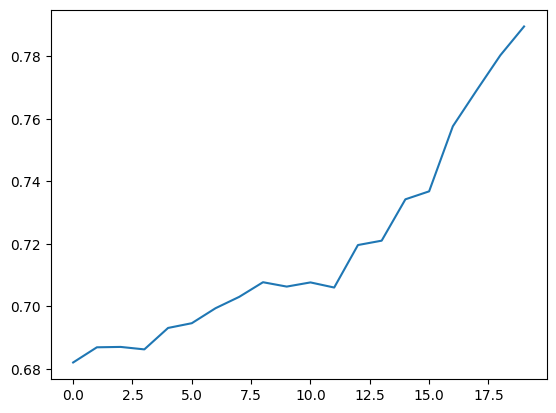

In [100]:
plt.figure()
plt.plot(history.history["Accuracy"])
plt.show()

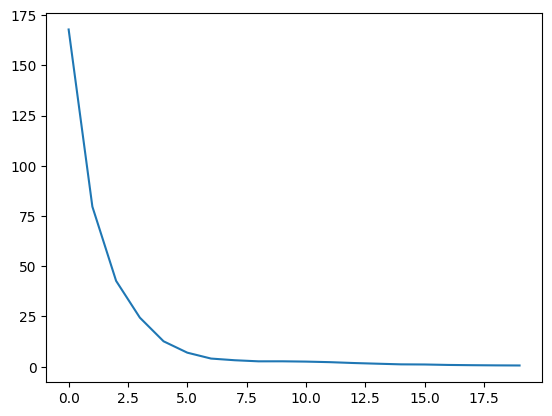

In [101]:
plt.figure()
plt.plot(history.history["loss"])
plt.show()

In [102]:
dnn_model.evaluate(X_test, y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.7832 - loss: 0.7973


[0.8271507024765015, 0.7891862392425537]

In [115]:
class AttentionLayer(Model):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(4, 100)

    def call(self,inputs):
        in1, in2, in3 = inputs
        out1, out2 = self.attention(in1, in2, in3, return_attention_scores=True)
        return out1, out2

In [116]:
input_layer = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,1))

attn_layer = AttentionLayer()
x, attn_scores = attn_layer([input_layer, input_layer, input_layer])

x = keras.layers.Conv1D(64, 3, activation="relu")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(100, activation="relu")(x)
x = keras.layers.Dense(50, activation="relu")(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

attn_model = Model(input_layer, output)

attn_model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["Accuracy"])

In [117]:
attn_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 100, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer_1         │ [(None, 100, 1),       │          2,801 │ input_layer_4[0][0],   │
│ (AttentionLayer)          │ (None, 4, 100, 100)]   │                │ input_layer_4[0][0],   │
│                           │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 98, 64)         │            256 │ attention_layer_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6272)           │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 100)            │        627,300 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 50)             │          5,050 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 1)              │             51 │ dense_13[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 635,458 (2.42 MB)

 Trainable params: 635,458 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
history = attn_model.fit(X_train, y_train, batch_size=16, epochs=15)

Epoch 1/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - Accuracy: 0.7540 - loss: 3.4290
Epoch 2/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 69s 66ms/step - Accuracy: 0.8297 - loss: 0.4674
Epoch 3/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - Accuracy: 0.8269 - loss: 0.4612
Epoch 4/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 70s 68ms/step - Accuracy: 0.8273 - loss: 0.4607
Epoch 5/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 77s 64ms/step - Accuracy: 0.8274 - loss: 0.4603
Epoch 6/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - Accuracy: 0.8289 - loss: 0.4581
Epoch 7/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 83s 65ms/step - Accuracy: 0.8270 - loss: 0.4610
Epoch 8/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 69s 66ms/step - Accuracy: 0.8202 - loss: 0.4719
Epoch 9/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - Accuracy: 0.8216 - loss: 0.4689
Epoch 10/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - Accuracy: 0.8291 - loss: 0.4577
Epoch 11/15
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - Accuracy: 0.8240 - loss: 0.4750
Epoch 12

In [107]:
attn_model.evaluate(X_test, y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Accuracy: 0.7979 - loss: 0.5060


[0.4812525808811188, 0.8137629628181458]

In [108]:
attn_model.layers

[<InputLayer name=input_layer_3, built=True>,
 <AttentionLayer name=attention_layer, built=True>,
 <Conv1D name=conv1d, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense_9, built=True>,
 <Dense name=dense_10, built=True>,
 <Dense name=dense_11, built=True>]

In [109]:
visualize_attn_scores = Model(attn_model.inputs, attn_model.layers[1].output[1])

In [110]:
attn_mats = visualize_attn_scores.predict(X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [111]:
attn_mats[0].shape

(100, 100)

In [119]:
index_obs = 7

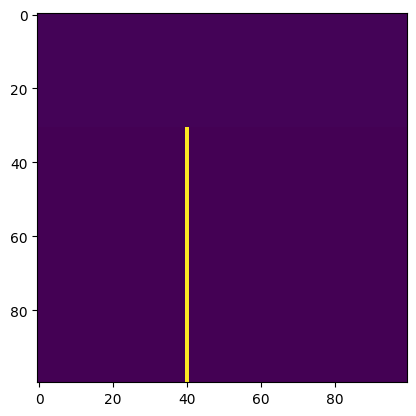

In [112]:
plt.imshow(attn_mats[10])

In [113]:
X_test_txt = t.sequences_to_texts(test_sequences)

In [114]:
X_test_txt[0].split(" ")[np.argmax(attn_mats[10].mean(axis=0))-2:np.argmax(attn_mats[10].mean(axis=0))+3]

['dining', 'room', 'kitchen', 'area', 'surprisingly']